In [189]:
import random
from matplotlib import pyplot as plt 
import statistics

# Constants
m = 64
T = 1000

In [190]:
def d_choice(d):
    return [random.choice(range(m)) for _ in range(d)]

def one_choice():
    return d_choice(1)

def two_choice():
    return d_choice(2)

def three_choice():
    return d_choice(3)

def beta_choice(beta):
    r = random.uniform(0, 1)
    if (r < beta):
        return one_choice()
    else:
        return two_choice()

def beta_one_quarter():
    return beta_choice(0.25)

def beta_two_quarters():
    return beta_choice(0.50)

def beta_three_quarters():
    return beta_choice(0.75)

In [191]:
def select_lowest_load(candidates, load):
    selected = candidates[0]
    for candidate in candidates:
        if (load[candidate] < load[selected]):
            selected = candidate
    return selected

def select_by_median(candidates, load):
    med = statistics.median(load)
    selected = candidates[0]
    for candidate in candidates:
        if (load[candidate] < med):
            selected = candidate
    return selected

def select_by_two_queries(candidates, load):
    med = statistics.median(load)
    heavy_loaded_med = statistics.quantiles(load, n=4)[2]
    light_loaded_med = statistics.quantiles(load, n=4)[0]
    
    heavy_loaded = []
    light_loaded = []
    for candidate in candidates:
        if (load[candidate] < med):
            light_loaded.append(candidate)
        else:
            heavy_loaded.append(candidate)

    selected = candidates[0]
    if len(light_loaded) > 0:
        selected = light_loaded[0]
        for candidate in light_loaded:
            if (load[candidate] < light_loaded_med):
                selected = candidate

    else:
        selected = heavy_loaded[0]
        for candidate in heavy_loaded:
            if (load[candidate] < heavy_loaded_med):
                selected = candidate
            
    return selected

In [192]:
def experiment(select_bin, select_candidates):
    G = [0 for _ in range(m*m + 1)]
    for _ in range(T):
        load = [0 for _ in range(m)]
        for n in range(1, m*m + 1):
            candidates = select_candidates()
            selected = select_bin(candidates, load)
            load[selected] += 1
            G[n] += max(load) - n/m

    G = [x/T for x in G]
    return G
            
#print(experiment(select_lowest_load, one_choice))

In [193]:
result_one_choice = experiment(select_lowest_load, one_choice)
result_two_choice = experiment(select_lowest_load, two_choice)
result_beta_one_quarter_choice = experiment(select_lowest_load, beta_one_quarter)
result_beta_two_quarters_choice = experiment(select_lowest_load, beta_two_quarters)
result_beta_three_quarters_choice = experiment(select_lowest_load, beta_three_quarters)

In [194]:
x = range(m*m + 1)

y_one_choice = [result_one_choice[i] for i in x]
y_two_choice = [result_two_choice[i] for i in x]
y_beta_one_quarter_choice = [result_beta_one_quarter_choice[i] for i in x]
y_beta_two_quarters_choice = [result_beta_two_quarters_choice[i] for i in x]
y_beta_three_quarters_choice = [result_beta_three_quarters_choice[i] for i in x]

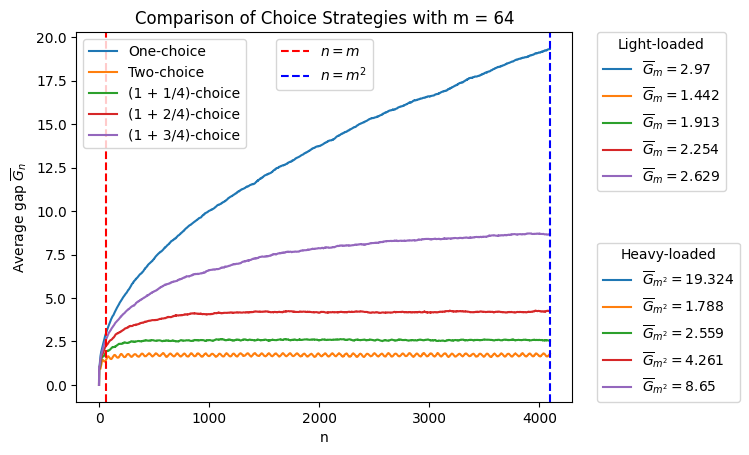

In [195]:
# Plot the data
line1, = plt.plot(x, y_one_choice, label="One-choice")
line2, = plt.plot(x, y_two_choice, label="Two-choice")
line3, = plt.plot(x, y_beta_one_quarter_choice, label="(1 + 1/4)-choice")
line4, = plt.plot(x, y_beta_two_quarters_choice, label="(1 + 2/4)-choice")
line5, = plt.plot(x, y_beta_three_quarters_choice, label="(1 + 3/4)-choice")

# Add vertical lines at n = m and n = m*m
line_v1 = plt.axvline(x=m, color="red", linestyle="--", label=r'$n = m$')
line_v2 = plt.axvline(x=m*m, color="blue", linestyle="--", label=r"$n = m^2$")

# First legend for the main lines
first_legend = plt.legend(handles=[line1, line2, line3, line4, line5], loc='upper left')
plt.gca().add_artist(first_legend)

# Second legend for the vertical lines
second_legend = plt.legend(handles=[line_v1, line_v2], loc='upper center')
plt.gca().add_artist(second_legend)

# Third legend for the values on the light-loaded scenario
light_loaded_labels = [r'$\overline{G}_m = $' + f'{y_one_choice[m]}',
                       r'$\overline{G}_m = $' + f'{y_two_choice[m]}',
                       r'$\overline{G}_m = $' + f'{y_beta_one_quarter_choice[m]}',
                       r'$\overline{G}_m = $' + f'{y_beta_two_quarters_choice[m]}',
                       r'$\overline{G}_m = $' + f'{y_beta_three_quarters_choice[m]}']
third_legend = plt.legend(title="Light-loaded", handles=[line1, line2, line3, line4, line5], labels = light_loaded_labels,loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.gca().add_artist(third_legend)

# Fourth legend for the values on the light-loaded scenario
heavy_loaded_labels = [r'$\overline{G}_{m^2} = $' + f'{y_one_choice[m*m]}',
                       r'$\overline{G}_{m^2} = $' + f'{y_two_choice[m*m]}',
                       r'$\overline{G}_{m^2} = $' + f'{y_beta_one_quarter_choice[m*m]}',
                       r'$\overline{G}_{m^2} = $' + f'{y_beta_two_quarters_choice[m*m]}',
                       r'$\overline{G}_{m^2} = $' + f'{y_beta_three_quarters_choice[m*m]}']
fourth_legend = plt.legend(title="Heavy-loaded", handles=[line1, line2, line3, line4, line5], labels = heavy_loaded_labels,loc='lower left', bbox_to_anchor=(1.05, 0), borderaxespad=0.)


# Add a title and labels
plt.title("Comparison of Choice Strategies with m = " + str(m))
plt.xlabel("n")
plt.ylabel("Average gap " + r'$\overline{G}_n$')

# Show the plot
plt.show()

In [196]:
def batched_experiment(select_candidates, select_bin, batch_size):
    l = m*m//batch_size + ((m*m)%batch_size > 0)
    G = [0 for _ in range(l + 1)]
    T_batched = 64*batch_size
    for _ in range(T_batched):
        load = [0 for _ in range(m)]
        for i in range(1, l + 1):
            n = i*batch_size
            candidates = select_candidates()
            selected = select_bin(candidates, load)
            load[selected] += batch_size
            G[i] += max(load) - n/m

    G = [x/T_batched for x in G]
    return G

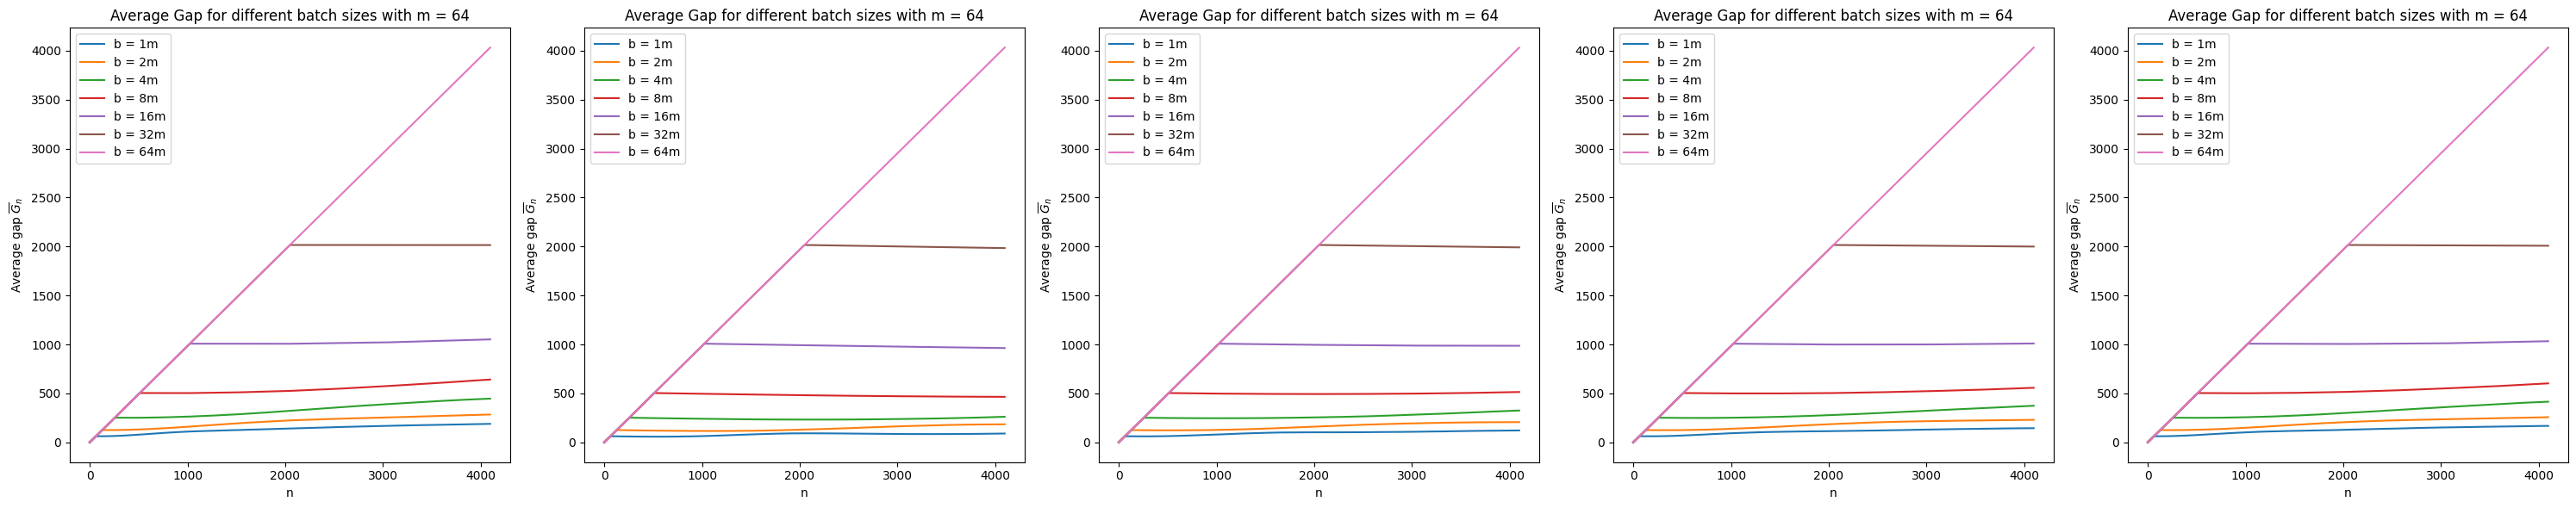

In [197]:
# Creating a 1x2 grid of subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 5, figsize=(5*6, 6))

choice_method = [one_choice, two_choice, beta_one_quarter, beta_two_quarters, beta_three_quarters]

for z in range(5):
    choice = choice_method[z]
    
    for k in [2**i for i in range(7)]:
        b = k*m
        l = m*m//b + ((m*m)%b > 0)
        
        x_b = [b*i for i in range(l + 1)]
        y_b = batched_experiment(choice, select_lowest_load, b)
        
        # Plotting the data
        ax[z].plot(x_b, y_b, label="b = " + str(k) + "m")
        
        ax[z].legend()
        ax[z].set_title("Average Gap for different batch sizes with m = " + str(m))
        ax[z].set_xlabel("n")
        ax[z].set_ylabel("Average gap " + r'$\overline{G}_n$')

plt.tight_layout()  # Adjust layout to make it look nicer
plt.show()

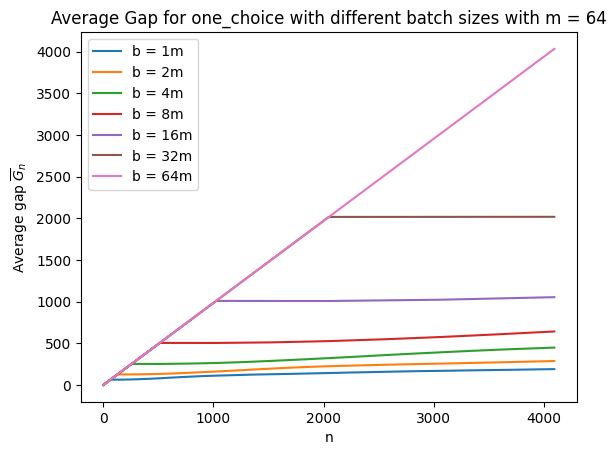

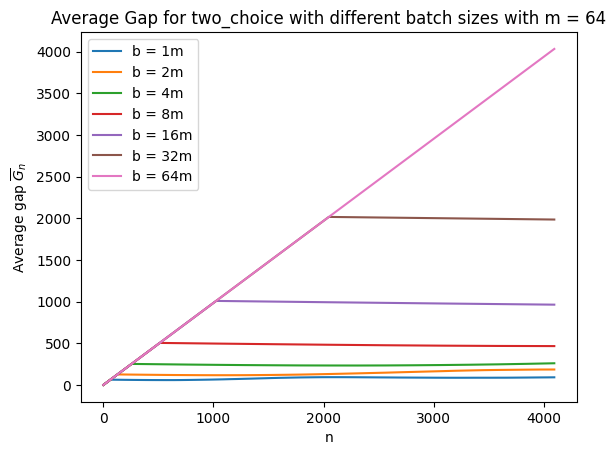

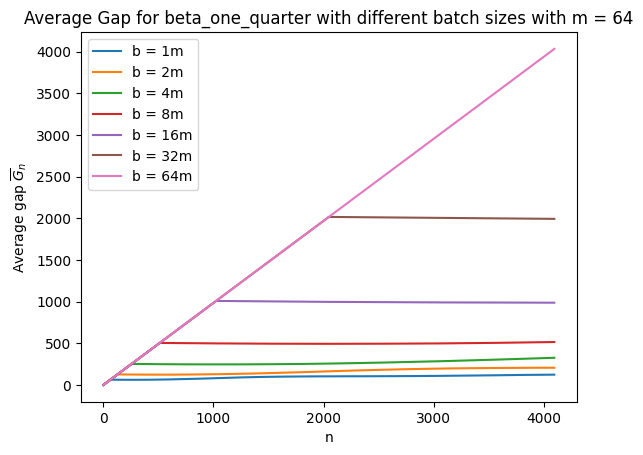

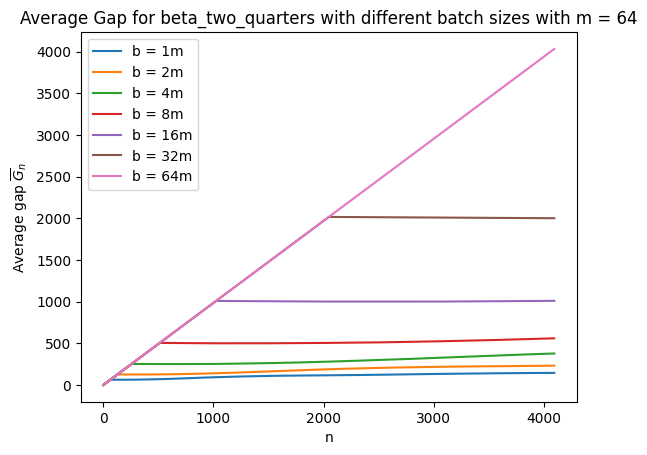

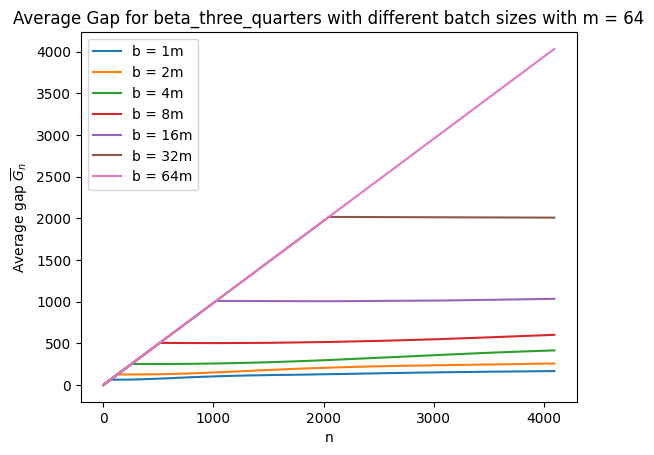

In [198]:
choice_method = [one_choice, two_choice, beta_one_quarter, beta_two_quarters, beta_three_quarters]

for z in range(5):
    choice = choice_method[z]
    
    for k in [2**i for i in range(7)]:
        b = k*m
        l = m*m//b + ((m*m)%b > 0)
        
        x_b = [b*i for i in range(l + 1)]
        y_b = batched_experiment(choice, select_lowest_load, b)
        
        # Plotting the data
        plt.plot(x_b, y_b, label="b = " + str(k) + "m")
        
    plt.legend()

    
    plt.title(f"Average Gap for {choice.__name__} with different batch sizes with m = " + str(m))
    plt.xlabel("n")
    plt.ylabel("Average gap " + r'$\overline{G}_n$')
    plt.show()

In [199]:
result_one_choice_by_median = experiment(select_by_median, one_choice)
result_two_choice_by_median = experiment(select_by_median, two_choice)
result_beta_one_quarter_choice_by_median = experiment(select_by_median, beta_one_quarter)
result_beta_two_quarters_choice_by_median = experiment(select_by_median, beta_two_quarters)
result_beta_three_quarters_choice_by_median = experiment(select_by_median, beta_three_quarters)

In [200]:
x_by_median = range(m*m + 1)

y_one_choice_by_median = [result_one_choice_by_median[i] for i in x_by_median]
y_two_choice_by_median = [result_two_choice_by_median[i] for i in x_by_median]
y_beta_one_quarter_choice_by_median = [result_beta_one_quarter_choice_by_median[i] for i in x_by_median]
y_beta_two_quarters_choice_by_median = [result_beta_two_quarters_choice_by_median[i] for i in x_by_median]
y_beta_three_quarters_choice_by_median = [result_beta_three_quarters_choice_by_median[i] for i in x_by_median]

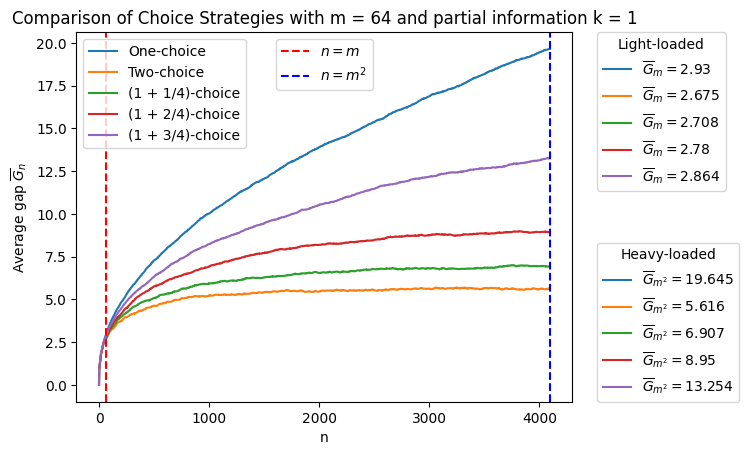

In [201]:
# Plot the data
line1, = plt.plot(x_by_median, y_one_choice_by_median, label="One-choice")
line2, = plt.plot(x_by_median, y_two_choice_by_median, label="Two-choice")
line3, = plt.plot(x_by_median, y_beta_one_quarter_choice_by_median, label="(1 + 1/4)-choice")
line4, = plt.plot(x_by_median, y_beta_two_quarters_choice_by_median, label="(1 + 2/4)-choice")
line5, = plt.plot(x_by_median, y_beta_three_quarters_choice_by_median, label="(1 + 3/4)-choice")

# Add vertical lines at n = m and n = m*m
line_v1 = plt.axvline(x=m, color="red", linestyle="--", label=r'$n = m$')
line_v2 = plt.axvline(x=m*m, color="blue", linestyle="--", label=r"$n = m^2$")

# First legend for the main lines
first_legend = plt.legend(handles=[line1, line2, line3, line4, line5], loc='upper left')
plt.gca().add_artist(first_legend)

# Second legend for the vertical lines
second_legend = plt.legend(handles=[line_v1, line_v2], loc='upper center')
plt.gca().add_artist(second_legend)

# Third legend for the values on the light-loaded scenario
light_loaded_labels = [r'$\overline{G}_m = $' + f'{y_one_choice_by_median[m]}',
                       r'$\overline{G}_m = $' + f'{y_two_choice_by_median[m]}',
                       r'$\overline{G}_m = $' + f'{y_beta_one_quarter_choice_by_median[m]}',
                       r'$\overline{G}_m = $' + f'{y_beta_two_quarters_choice_by_median[m]}',
                       r'$\overline{G}_m = $' + f'{y_beta_three_quarters_choice_by_median[m]}']
third_legend = plt.legend(title="Light-loaded", handles=[line1, line2, line3, line4, line5], labels = light_loaded_labels,loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.gca().add_artist(third_legend)

# Fourth legend for the values on the light-loaded scenario
heavy_loaded_labels = [r'$\overline{G}_{m^2} = $' + f'{y_one_choice_by_median[m*m]}',
                       r'$\overline{G}_{m^2} = $' + f'{y_two_choice_by_median[m*m]}',
                       r'$\overline{G}_{m^2} = $' + f'{y_beta_one_quarter_choice_by_median[m*m]}',
                       r'$\overline{G}_{m^2} = $' + f'{y_beta_two_quarters_choice_by_median[m*m]}',
                       r'$\overline{G}_{m^2} = $' + f'{y_beta_three_quarters_choice_by_median[m*m]}']
fourth_legend = plt.legend(title="Heavy-loaded", handles=[line1, line2, line3, line4, line5], labels = heavy_loaded_labels,loc='lower left', bbox_to_anchor=(1.05, 0), borderaxespad=0.)


# Add a title and labels
plt.title("Comparison of Choice Strategies with m = " + str(m) + " and partial information k = 1")
plt.xlabel("n")
plt.ylabel("Average gap " + r'$\overline{G}_n$')

# Show the plot
plt.show()

In [202]:
result_one_choice_by_two_queries = experiment(select_by_two_queries, one_choice)
result_two_choice_by_two_queries = experiment(select_by_two_queries, two_choice)
result_beta_one_quarter_choice_by_two_queries = experiment(select_by_two_queries, beta_one_quarter)
result_beta_two_quarters_choice_by_two_queries = experiment(select_by_two_queries, beta_two_quarters)
result_beta_three_quarters_choice_by_two_queries = experiment(select_by_two_queries, beta_three_quarters)

In [203]:
x_by_two_queries = range(m*m + 1)

y_one_choice_by_two_queries = [result_one_choice_by_two_queries[i] for i in x_by_two_queries]
y_two_choice_by_two_queries = [result_two_choice_by_two_queries[i] for i in x_by_two_queries]
y_beta_one_quarter_choice_by_two_queries = [result_beta_one_quarter_choice_by_two_queries[i] for i in x_by_two_queries]
y_beta_two_quarters_choice_by_two_queries = [result_beta_two_quarters_choice_by_two_queries[i] for i in x_by_two_queries]
y_beta_three_quarters_choice_by_two_queries = [result_beta_three_quarters_choice_by_two_queries[i] for i in x_by_two_queries]

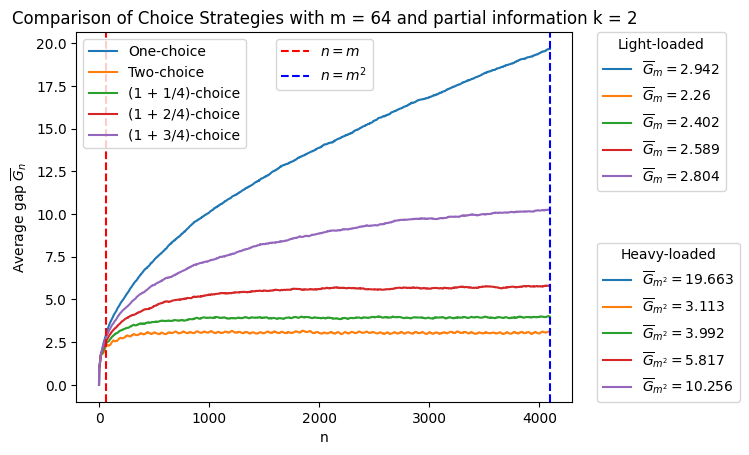

In [204]:
# Plot the data
line1, = plt.plot(x_by_two_queries, y_one_choice_by_two_queries, label="One-choice")
line2, = plt.plot(x_by_two_queries, y_two_choice_by_two_queries, label="Two-choice")
line3, = plt.plot(x_by_two_queries, y_beta_one_quarter_choice_by_two_queries, label="(1 + 1/4)-choice")
line4, = plt.plot(x_by_two_queries, y_beta_two_quarters_choice_by_two_queries, label="(1 + 2/4)-choice")
line5, = plt.plot(x_by_two_queries, y_beta_three_quarters_choice_by_two_queries, label="(1 + 3/4)-choice")

# Add vertical lines at n = m and n = m*m
line_v1 = plt.axvline(x=m, color="red", linestyle="--", label=r'$n = m$')
line_v2 = plt.axvline(x=m*m, color="blue", linestyle="--", label=r"$n = m^2$")

# First legend for the main lines
first_legend = plt.legend(handles=[line1, line2, line3, line4, line5], loc='upper left')
plt.gca().add_artist(first_legend)

# Second legend for the vertical lines
second_legend = plt.legend(handles=[line_v1, line_v2], loc='upper center')
plt.gca().add_artist(second_legend)

# Third legend for the values on the light-loaded scenario
light_loaded_labels = [r'$\overline{G}_m = $' + f'{y_one_choice_by_two_queries[m]}',
                       r'$\overline{G}_m = $' + f'{y_two_choice_by_two_queries[m]}',
                       r'$\overline{G}_m = $' + f'{y_beta_one_quarter_choice_by_two_queries[m]}',
                       r'$\overline{G}_m = $' + f'{y_beta_two_quarters_choice_by_two_queries[m]}',
                       r'$\overline{G}_m = $' + f'{y_beta_three_quarters_choice_by_two_queries[m]}']
third_legend = plt.legend(title="Light-loaded", handles=[line1, line2, line3, line4, line5], labels = light_loaded_labels,loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.gca().add_artist(third_legend)

# Fourth legend for the values on the light-loaded scenario
heavy_loaded_labels = [r'$\overline{G}_{m^2} = $' + f'{y_one_choice_by_two_queries[m*m]}',
                       r'$\overline{G}_{m^2} = $' + f'{y_two_choice_by_two_queries[m*m]}',
                       r'$\overline{G}_{m^2} = $' + f'{y_beta_one_quarter_choice_by_two_queries[m*m]}',
                       r'$\overline{G}_{m^2} = $' + f'{y_beta_two_quarters_choice_by_two_queries[m*m]}',
                       r'$\overline{G}_{m^2} = $' + f'{y_beta_three_quarters_choice_by_two_queries[m*m]}']
fourth_legend = plt.legend(title="Heavy-loaded", handles=[line1, line2, line3, line4, line5], labels = heavy_loaded_labels,loc='lower left', bbox_to_anchor=(1.05, 0), borderaxespad=0.)


# Add a title and labels
plt.title("Comparison of Choice Strategies with m = " + str(m) + " and partial information k = 2")
plt.xlabel("n")
plt.ylabel("Average gap " + r'$\overline{G}_n$')

# Show the plot
plt.show()

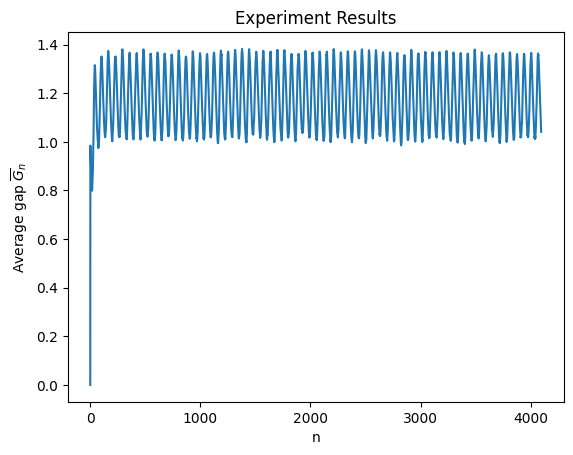

In [205]:
# Uncomment the desired lines to configure and run the experiment

# 1. Choose the bin selection method
bin_selection_method = select_lowest_load  # Options: select_lowest_load, select_by_median, select_by_two_queries

# 2. Choose the candidate bin selection method
candidate_bins_selection_method = three_choice  # Options: one_choice, two_choice, three_choice, beta_one_quarter, beta_two_quarters, beta_three_quarters

# 3. (Optional) Set the batch size for batched experiments
batch_size = m  # Set the batch size (e.g., m, 2*m, etc.)

# 4. Choose the experiment type
experiment_type = experiment  # Options: experiment, batched_experiment

# If using batched_experiment, you need to provide a batch_size
if experiment_type == batched_experiment:
    # Run the batched experiment with the selected configuration
    exp_result = batched_experiment(candidate_bins_selection_method, bin_selection_method, batch_size)
    l = m*m//batch_size + ((m*m)%batch_size > 0)
    x = [batch_size*i for i in range(l + 1)]
else:
    # Run the standard experiment
    exp_result = experiment(bin_selection_method, candidate_bins_selection_method)
    x = range(m*m + 1)

# 5. Plot the results
# x-values (range of experiment steps)


# Plot the experiment result
plt.plot(x, exp_result)

# Add title and labels
plt.title("Experiment Results")
plt.xlabel("n")
plt.ylabel("Average gap " + r'$\overline{G}_n$')

# Show the plot
plt.show()